<a href="https://colab.research.google.com/github/kkhendry/Benchmarking-Quantum-Groundstate-Solvers/blob/master/main/BenchmarkingTool.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Getting Started

#### Working with Remote VS Code Editor
To work using VSCode Editor, run cell 1 and 2 below. Input your own ngrok authentication token in cell 1 and access the VSCode ngrok tunnel by clicking the link in cell 2. Once you are in the VSCode editor there is no need to run cell 1 and 2 again.

In [ ]:
#@title Cell 1
#Uncomment '%%capture' below to hide output in Google Colab
#%%capture
!pip install colabcode
!wget -q -c -nc https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip -qq -n ngrok-stable-linux-amd64.zip
!./ngrok authtoken #add your own authtoken here. Log in/sign up for an ngrok account at https://ngrok.com/.
from colabcode import ColabCode


In [ ]:
#@title Cell 2
ColabCode(port=10000)

#### Working with Google Colab
To work from google colab, run cell 3. This option is great for running to notebook, but limited for editing helper and utility files and functions.

In [ ]:
#@title Cell 3
#Uncomment '%%capture' below to hide output in Google Colab
#%%capture
!git clone https://github.com/kkhendry/Benchmarking-Quantum-Groundstate-Solvers/.git
import sys
sys.path.insert(0, 'Benchmarking-Quantum-Groundstate-Solvers/')
%cd Benchmarking-Quantum-Groundstate-Solvers

#### Setting up git and installing requirements

Run cell 4 and 5 below to set up all the requirements to run the rest of the notebook. When dwave setup prompts you for an authentication token in cell 5, please use your own. You can sign up for a dwave leap account with limited usage at https://cloud.dwavesys.com/leap/login/?next=/leap/.

In [2]:
#@title Cell 4
#Uncomment '%%capture' below to hide output in Google Colab. If using vscode, simply copy and paste the code below in the terminal. For git config add your own email address and user name associated with your github account.
#%%capture
!git config --global user.email karan.khendry@gmail.com
!git config --global user.name hydraken
!pip install -r setup

In [ ]:
#@title Cell 5
#To use the real Leap D-Wave systems device backend, obtain a D-Wave Leap API token at https://cloud.dwavesys.com/leap/login/?next=/leap/ and enter it when prompted during 'dwave set up'. If you are simply using a simulator, you can skip the API token prompt.
!dwave setup

## On to the main event!

#### Import modules
Install all required modules in cell 6 below.

In [45]:
#@title Cell 6
#General
import numpy as np
import json
import scipy
import scipy.linalg
import math
import pandas as pd
import time
import re
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
from datetime import datetime
import pprint
pp = pprint.PrettyPrinter(indent=2)

#Molecule Drivers
# import pyscf
# from pyscf import gto, scf, mcscf

##QISKIT
#Molecule, Fermioninc Operator, Problem Definition
from qiskit_nature.drivers import Molecule
from qiskit_nature.operators.second_quantization import FermionicOp
from qiskit_nature.drivers.second_quantization.pyscfd import PySCFDriver
from qiskit_nature.drivers.second_quantization import ElectronicStructureDriverType, ElectronicStructureMoleculeDriver
from qiskit_nature.problems.second_quantization import ElectronicStructureProblem
from qiskit_nature.transformers.second_quantization.electronic import FreezeCoreTransformer
from qiskit_nature.transformers.second_quantization.electronic import ActiveSpaceTransformer

#Qubit Operator
from qiskit_nature.mappers.second_quantization import JordanWignerMapper, ParityMapper, BravyiKitaevMapper
from qiskit_nature.converters.second_quantization import QubitConverter

#Circuits, Simulators, Algorithms, Solvers and VQE
from qiskit_nature.circuit.library import HartreeFock
from qiskit.circuit.library import EfficientSU2, TwoLocal, NLocal, PauliTwoDesign
from qiskit_nature.circuit.library import UCCSD, PUCCD, SUCCD
from qiskit.algorithms import NumPyMinimumEigensolver
from qiskit_nature.algorithms import GroundStateEigensolver
from qiskit.providers.aer import StatevectorSimulator, QasmSimulator
from qiskit.algorithms.optimizers import COBYLA, L_BFGS_B, SPSA, SLSQP
from qiskit.algorithms import VQE
from qiskit_nature.algorithms import VQEUCCFactory, GroundStateEigensolver

##OPENFERMION
from openfermionpyscf import run_pyscf
from openfermion.transforms import binary_code_transform, bravyi_kitaev_code, get_fermion_operator
from openfermion.ops import FermionOperator, QubitOperator
from openfermion.utils import count_qubits
from openfermion.chem import MolecularData
from openfermion.transforms import get_fermion_operator, jordan_wigner
from openfermion.linalg import get_ground_state, get_sparse_operator
import numpy
import scipy
import scipy.linalg

##UTILITIES
from helper_functions import *
from XBK_method import *
from QCC_method import *

#### Set up molecule and electronic structure problem

Set up the molecule and electronic structure problem to work with in cell 7 below. Some example molecules have been set up below, uncomment the relevant sections to run experiements with those or create an equivalent code block with a molecule of your choice. H2 and H3 should work with both the simulators and real device backends in reasonable amounts of time (<15 minutes). LiH is where is starts to get challenging and requires further work to tune hyperparameters and reduce the active space.

In [26]:
#@title Cell 7

## MOLECULE SELECTION ##
############################

#H2
geometry = [['H', [  0.0,    0.0,    0.0]],
            ['H', [  0.0,    0.0,   0.739]]]
molecule = Molecule(geometry=geometry, charge=0, multiplicity=1)
molecule_name = 'H2'
basis = 'sto6g'

# # H3
# geometry = [['H', [0.0, 0.0, 0.0]], ['H', [1.1, 0.0, 0.0]], ['H', [0.55, 0.9526279441628825, 0]]]
# molecule = Molecule(geometry=geometry, charge=1, multiplicity=1)
# molecule_name = 'H3'
# basis = 'sto3g'

# #LiH
# geometry = [['Li', [0.0, 0.0, 0.0]], ['H', [0.0, 0.0, 1.5474]]]
# molecule = Molecule(geometry=geometry, charge=0, multiplicity=1)
# molecule_name = 'LiH'
# basis = 'sto3g'

# # H20
# geometry = [['O', [0.0, 0.0, 0.0]], ['H', [0.0, 0.0, 1.0]], ['H', [0.0, 1.0, 0.0]]]
# molecule = Molecule(geometry=geometry, charge=0, multiplicity=1)
# molecule_name = 'H20'
# basis = 'sto3g'

# #HCONH2
# geometry = [["O",  [1.1280, 0.2091, 0.0000]],
#             ["N", [-1.1878, 0.1791, 0.0000]],
#             ["C", [0.0598, -0.3882, 0.0000]],
#             ["H", [-1.3085, 1.1864, 0.0001]],
#             ["H", [-2.0305, -0.3861, -0.0001]],
#             ["H", [-0.0014, -1.4883, -0.0001]],
#             ['C', [-0.1805, 1.3955, 0.000]]]
# molecule = Molecule(geometry=geometry, charge=0, multiplicity=1)
# molecule_name = 'HCONH2'
# basis = 'sto3g'

############################


## ACTIVE SPACE REDUCTION ##
############################

two_qubit_reduction = True
freeze_core=True
remove_orbitals = None
z2symmetry_reduction = None

############################

class Problem: 
    def __init__(self, molecule, molecule_name, basis, geometry, two_qubit_reduction = True, freeze_core = True, remove_orbitals = None, z2symmetry_reduction = None):
        self.molecule = molecule
        self.molecule_name = molecule_name
        self.basis = basis
        self.geometry = str(geometry).replace(" ", "")
        self.two_qubit_reduction = two_qubit_reduction
        self.freeze_core = freeze_core
        self.remove_orbitals = remove_orbitals
        self.z2symmetry_reduction=z2symmetry_reduction
        self.freeze_core_transformer = FreezeCoreTransformer(freeze_core=self.freeze_core, remove_orbitals=self.remove_orbitals)

    def problemOperators(self, exact_solution = True):
        driver = ElectronicStructureMoleculeDriver(molecule=self.molecule, basis=self.basis, driver_type=ElectronicStructureDriverType.PYSCF)
        self.es_problem = ElectronicStructureProblem(driver, transformers=[self.freeze_core_transformer])
        self.second_q_op = self.es_problem.second_q_ops()
        self.q_fermionic_op = self.second_q_op[0]
        # register_length = q_fermionic_op.register_length
        self.of_fermionic_op = qiskit2of_fermionicOp(self.q_fermionic_op)

        self.qubit_converter = QubitConverter(JordanWignerMapper(), two_qubit_reduction=self.two_qubit_reduction, z2symmetry_reduction=self.z2symmetry_reduction)
        self.q_qubit_op = self.qubit_converter.convert(self.q_fermionic_op)
        self.of_qubit_op = jordan_wigner(self.of_fermionic_op)
        # m = count_qubits(qubit_H)
        # print(qubit_H)

        if exact_solution:
            numpy_solver = NumPyMinimumEigensolver()
            numpy_ground_state_solver = GroundStateEigensolver(self.qubit_converter, numpy_solver)
            numpy_results = numpy_ground_state_solver.solve(self.es_problem)
            self.exact_energy = numpy_results.computed_energies[0]
            print(f"Exact electronic energy: {self.exact_energy:.6f} Hartree\n")
            # print(numpy_results)

problem = Problem(molecule, molecule_name, basis, geometry, two_qubit_reduction=two_qubit_reduction, freeze_core=freeze_core, remove_orbitals=remove_orbitals)
problem.problemOperators()


Exact electronic energy: -1.862023 Hartree



#### Set up functions for processing groundstate energy results
Note: If using Google Colab, comment out json file database and image file code block as indicated in the cell below.

In [39]:
#@title Cell 7

def callback(eval_count, parameters, mean, std):  
    # Overwrites the same line when printing
    display("Evaluation: {}, Energy: {}, Std: {}".format(eval_count, mean, std))
    clear_output(wait=True)
    counts.append(eval_count)
    values.append(mean)
    params.append(parameters)
    deviation.append(std)

def minEnergyResults(problem, result_dict, key):
    # key = problem.molecule_name+"_"+problem.geometry+"_"+basis+"_"+method+"_"+backend+'_'+result_time
    fig, ax1 = plt.subplots(1, 1)
    fig.set_figwidth(12)
    fig.set_figheight(9)
    color = 'tab:blue'
    ax1.set_xlabel('Iterations')
    ax1.set_ylabel('Energy')
    ax1.plot(range(len(result_dict[key]['min energies'])), result_dict[key]['min energies'])
    ax1.axhline(result_dict[key]['exact energy'], linestyle='--')

    # ax2 = ax1.twinx() 
    # color = 'tab:orange'
    # ax2.set_ylabel('Time', color=color)
    # ax2.bar(range(len(min_energies)), iter_times, color=color, alpha = 0.2, width = 0.2)

    if method == 'VQE':
        fig_title = f"\
        {result_dict[key]['setup']['mapping']}-\
        {result_dict[key]['setup']['ansatz']}-\
        {result_dict[key]['setup']['optimizer']}"
        plt.title(method+" Convergence Plot\n"+fig_title)
    elif method == 'QCC':
        fig_title = f"\
        {result_dict[key]['setup']['mapping']}-\
        {result_dict[key]['setup']['angle_folds']}-\
        {result_dict[key]['setup']['amplitude_folds']}"
        plt.title(method+" Convergence Plot\n"+fig_title)
    elif method == 'XBK':
        fig_title = f"\
        {result_dict[key]['setup']['mapping']}-\
        {result_dict[key]['setup']['r']}"
        plt.title(method+" Convergence Plot\n"+fig_title)

    newline = '\n'
    fig.text(0.65, 0.75, f"\
        Minimum Energy: {result_dict[key]['result energy (Ha)']:.3f}{newline}\
        Runtime: {result_dict[key]['runtime']:.3f}{newline}\
        Number of Iterations: {result_dict[key]['# of evaluations']}")

    ## Comment out this block in google colab
    if os.path.exists('experiments/results.json'):
        with open('experiments/results.json', 'r') as file:
            results = json.loads(file.read())
            results.update(result_dict)
    else:
        with open('experiments/results.json', 'w') as outfile:  
            json.dump({}, outfile)
        results = result_dict

    with open('experiments/results.json','w') as outfile:
        json.dump(results, outfile, sort_keys=True, indent=4)

    fig.savefig('experiments/'+key+'.png')
    ## Comment out this block in google colab

    pp.pprint(result_dict)

#### Set up IBM backend for VQE (and future QAOA)

Set up the IBM Quantum Device backend in cell 9 below. Comment out as appropriate if you want to use the simulator or the real device backend.
For the real device backend, please use your own IBM Quantum authentication API token. You can login/sign up for an IBM Quantum account at https://quantum-computing.ibm.com/

In [32]:
#@title Cell 9

## Real Device Backend
# from qiskit import IBMQ
# IBMQ.save_account('') # enter your IBMQ API token here. You can obtain an IBMQ account at https://quantum-computing.ibm.com/
# provider = IBMQ.load_account()
# # provider = IBMQ.get_provider(project='qiskit-runtime')  # Change this to your provider.
# backend = provider.get_backend('ibmq_qasm_simulator')

## Simulated Backend
backend = QasmSimulator()

#### Set up IBM backend for VQE (and future QAOA)

Set up the D-Wave Systems Device backend in cell 10 below. Comment out as appropriate if you want to use the simulator or the real device backend.
For the real device backend, please use your own D-Wave systems authentication API token. You can login/sign up for a Leap D-Wave systems account at https://cloud.dwavesys.com/leap/login/?next=/leap/

In [33]:
#@title Cell 10

## Real Device Backend
# from dwave.system import LeapHybridSampler
# sampler = LeapHybridSampler()

## Simulated Backend
from neal import SimulatedAnnealingSampler
sampler = SimulatedAnnealingSampler() #uses simulated annealing, see D-Wave's ocean sdk for more options

sampler_name = re.search(r'sampler\.(.*?)object', str(sampler)).group(1)

## This is where the fun begins!

#### VQE (IBM Qiskit)
Run cell 11 below to run VQE. Refer to [REFERENCES]

{ "H2_[['H',[0.0,0.0,0.0]],['H',[0.0,0.0,0.739]]]_sto6g_VQE_qasm_simulator_19Jan2022_13:53:47": { '# of evaluations': 40,
                                                                                                  '# of qubits': 4,
                                                                                                  'accuracy (%)': 95.81335139373938,
                                                                                                  'backend': 'qasm_simulator',
                                                                                                  'basis': 'sto6g',
                                                                                                  'error (mHa)': 0.07795634960711739,
                                                                                                  'exact energy': -1.8620227522926889,
                                                                                                  'final parameters':

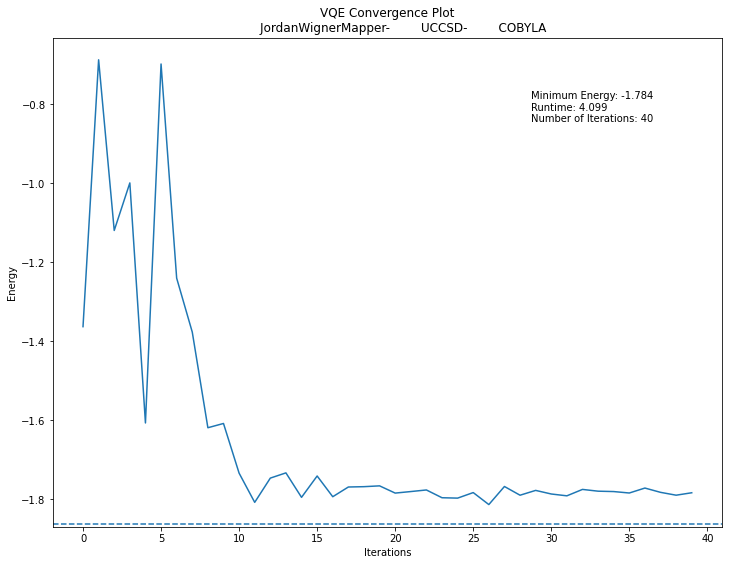

In [40]:
#@title Cell 11

method = "VQE"
init_state = HartreeFock(problem.es_problem.num_spin_orbitals, problem.es_problem.num_particles, problem.qubit_converter)

## Ansatz
from qiskit.circuit.library import TwoLocal
from qiskit_nature.circuit.library import UCCSD, PUCCD, SUCCD

ansatz_type = "UCCSD"
if ansatz_type == "TwoLocal":
    rotation_blocks = ['ry', 'rz']
    entanglement_blocks = 'cx'
    entanglement = 'full'
    repetitions = 3
    skip_final_rotation_layer = True
    ansatz = TwoLocal(problem.q_qubit_op.num_qubits, rotation_blocks, entanglement_blocks, reps=repetitions, 
                      entanglement=entanglement, skip_final_rotation_layer=skip_final_rotation_layer)
    ansatz.compose(init_state, front=True, inplace=True)
elif ansatz_type == "UCCSD":
    ansatz = UCCSD(problem.qubit_converter,problem.es_problem.num_particles,problem.es_problem.num_spin_orbitals,initial_state = init_state)
elif ansatz_type == "PUCCD":
    ansatz = PUCCD(problem.qubit_converter,problem.es_problem.num_particles,problem.es_problem.num_spin_orbitals,initial_state = init_state)
elif ansatz_type == "SUCCD":
    ansatz = SUCCD(problem.qubit_converter,problem.es_problem.num_particles,problem.es_problem.num_spin_orbitals,initial_state = init_state)

## Optimizer
from qiskit.algorithms.optimizers import COBYLA, L_BFGS_B, SPSA, SLSQP

optimizer_type = 'COBYLA'
if optimizer_type == 'COBYLA':
    optimizer = COBYLA(maxiter=500)
elif optimizer_type == 'L_BFGS_B':
    optimizer = L_BFGS_B(maxfun=500)
elif optimizer_type == 'SPSA':
    optimizer = SPSA(maxiter=500)
elif optimizer_type == 'SLSQP':
    optimizer = SLSQP(maxiter=500)

#how about freeze core, Z2symmetry reduction and removed orbitals?
if ansatz_type == "TwoLocal":
    param_dict = {
        'optimizer': optimizer.__class__.__name__,
        'mapping': problem.qubit_converter.mapper.__class__.__name__,
        'ansatz': ansatz.__class__.__name__,
        'rotation blocks': rotation_blocks,
        'entanglement_blocks': entanglement_blocks,
        'entanglement': entanglement,
        'repetitions': repetitions,
        'skip_final_rotation_layer': skip_final_rotation_layer}
else:
    param_dict = {
        'optimizer': optimizer.__class__.__name__,
        'mapping': problem.qubit_converter.mapper.__class__.__name__,
        'ansatz': ansatz.__class__.__name__,
        'rotation blocks': None,
        'entanglement_blocks': None,
        'entanglement': None,
        'repetitions': None,
        'skip_final_rotation_layer': None}

np.random.seed(5)  # fix seed for reproducibility
initial_point = np.random.random(ansatz.num_parameters)

iter_times = []
counts = []
values = []
params = []
deviation = []

algorithm = VQE(ansatz,
                optimizer=optimizer,
                quantum_instance=backend,
                callback=callback,
                initial_point=initial_point)

result = algorithm.compute_minimum_eigenvalue(problem.q_qubit_op)
exact_energy = problem.exact_energy
min_energy = np.real(result.eigenvalue)
optimal_state = result.eigenstate
optimal_point = result.optimal_point
percent_accuracy = 100-np.abs(100*(min_energy-exact_energy)/exact_energy)
nominal_accuracy = min_energy-exact_energy
min_energies = values
result_time = datetime.now().strftime("%d%b%Y_%H:%M:%S")
key = problem.molecule_name+"_"+problem.geometry+"_"+basis+"_"+method+"_"+str(backend)+"_"+result_time

result_dict = {
    key:
        {
        'molecule': problem.molecule_name,
        'geometry': problem.geometry,
        'basis': problem.basis,
        'two_qubit_reduction': problem.two_qubit_reduction,
        'freeze_core': problem.freeze_core,
        'remove_orbitals': problem.remove_orbitals,
        'z2symmetry_reduction': problem.z2symmetry_reduction,
        'result_time': result_time,
        'method': method,
        'backend': str(backend),
        'setup' : param_dict,
        'exact energy': problem.exact_energy,
        'result energy (Ha)': min_energy,
        'error (mHa)': nominal_accuracy,
        'accuracy (%)': percent_accuracy,
        'final parameters': list(optimal_point),
        '# of evaluations': len(min_energies),
        'runtime': result.optimizer_time,
        '# of qubits': int(problem.q_qubit_op.num_qubits),
        'min energies': list(min_energies)
        }
}

minEnergyResults(problem, result_dict, key)

#### QCC (D-Wave Systems)
Run cell 12 to run QCC.

Code from cell 13 and QCC_method.py has been adapted from https://github.com/jcopenh/Quantum-Chemistry-with-Annealers. 

Refer to 'J. Copenhaver, A. Wasserman, and B. Wehefritz-Kaufmann. “Using Quantum Annealers to Calculate Ground State 
    Properties of Molecules,” (2020), arXiv:2009.10779v2 [quant-ph].'

Cycle: 1 Energy: -1.4298441862047184
Cycle: 2 Energy: 0.3524577917996794
Cycle: 3 Energy: -0.4296235556976171
Cycle: 4 Energy: -1.4182674367038999
Cycle: 5 Energy: 0.5045382685784716
Cycle: 6 Energy: -0.36833506052789744
Cycle: 7 Energy: 0.8718837111227913
Cycle: 8 Energy: 1.0923989054572303
Cycle: 9 Energy: 0.607303674943978
Cycle: 10 Energy: -0.35709848847182
{ "H2_[['H',[0.0,0.0,0.0]],['H',[0.0,0.0,0.739]]]_sto6g_QCC_SimulatedAnnealingSampler _19Jan2022_13:56:56": { '# of evaluations': 10,
                                                                                                              '# of qubits': 4,
                                                                                                              'accuracy (%)': 76.7898343048798,
                                                                                                              'backend': 'SimulatedAnnealingSampler ',
                                                                               

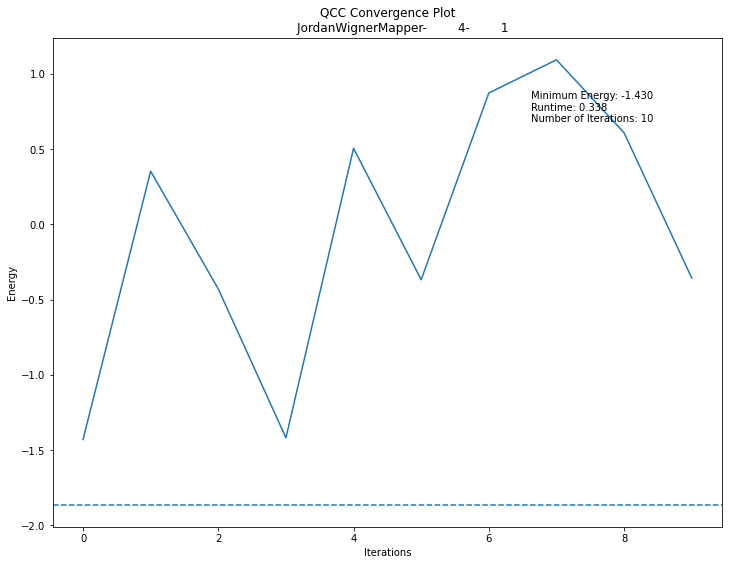

In [41]:
#@title Cell 12

#set number of Bloch angle and entangler amplitude foldings
method = 'QCC'
start_time = time.time()

angle_folds = 4
amplitude_folds = 1
m = count_qubits(problem.of_qubit_op)
#create dictionary of QubitOperator entanglers
entanglers = {'IYZI': QubitOperator('Y1 Z2'), 'IZYI': QubitOperator('Z1 Y2'),
              'IXYI': QubitOperator('X1 Y2'), 'IYXI': QubitOperator('Y1 X2')}

param_dict = {
    'mapping': problem.qubit_converter.mapper.__class__.__name__,
    'angle_folds': angle_folds,
    'amplitude_folds': amplitude_folds,
    'entanglers': str(entanglers)}

#run QCC method
min_energy, variables, min_energies, iter_times = QCC(problem.of_qubit_op, entanglers, angle_folds, amplitude_folds, sampler, num_cycles=10, num_samples=1000, strength=1e3, verbose=True)

exact_energy = problem.exact_energy
min_energy = np.real(min_energy)
optimal_point = variables
percent_accuracy = 100-np.abs(100*(min_energy-exact_energy)/exact_energy)
nominal_accuracy = min_energy-exact_energy
result_time = datetime.now().strftime("%d%b%Y_%H:%M:%S")
key = problem.molecule_name+"_"+problem.geometry+"_"+basis+"_"+method+"_"+sampler_name+"_"+result_time

result_dict = {
    key:
        {
        'molecule': problem.molecule_name,
        'geometry': problem.geometry,
        'basis': problem.basis,
        'method': method,
        'two_qubit_reduction': problem.two_qubit_reduction,
        'freeze_core': problem.freeze_core,
        'remove_orbitals': problem.remove_orbitals,
        'z2symmetry_reduction': problem.z2symmetry_reduction,
        'result_time': result_time,
        'backend': sampler_name,
        'setup' : param_dict,
        'exact energy': exact_energy,
        'result energy (Ha)': min_energy,
        'error (mHa)': nominal_accuracy,
        'accuracy (%)': percent_accuracy,
        'final parameters': str(optimal_point),
        '# of evaluations': len(min_energies),
        'runtime': sum(iter_times),
        '# of qubits': m,
        'min energies': list(min_energies)
        }

}

minEnergyResults(problem, result_dict, key)

#### XBX (D-Wave Systems)
Run cell 13 below to run XBK. 

Code from cell 13 and XBK_method.py has been adapted from https://github.com/jcopenh/Quantum-Chemistry-with-Annealers. 

Refer to 'J. Copenhaver, A. Wasserman, and B. Wehefritz-Kaufmann. “Using Quantum Annealers to Calculate Ground State 
    Properties of Molecules,” (2020), arXiv:2009.10779v2 [quant-ph].'


P: 0 E: 0
P: 1 E: -1.2748
P: 2 E: 0
Energy: -1.2748
{ "H2_[['H',[0.0,0.0,0.0]],['H',[0.0,0.0,0.739]]]_sto6g_XBK_SimulatedAnnealingSampler _19Jan2022_13:57:36": { '# of evaluations': 3,
                                                                                                              '# of qubits': 4,
                                                                                                              'accuracy (%)': 68.46330694835116,
                                                                                                              'backend': 'SimulatedAnnealingSampler ',
                                                                                                              'basis': 'sto6g',
                                                                                                              'error (mHa)': 0.5872203999424088,
                                                                                                              'exact e

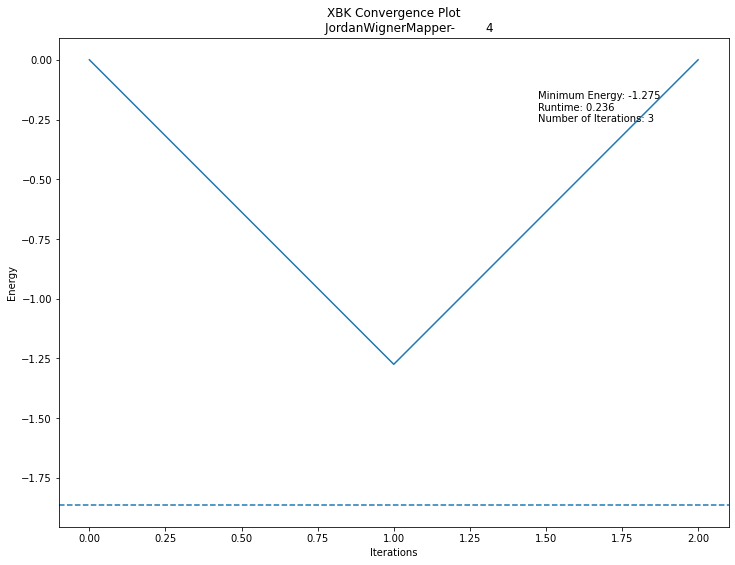

In [43]:
#@title Cell 13

method = 'XBK'
start_time = time.time()
#set r value
r = 4

#construct qubit Hamiltonians and C terms for XBK method
qubit_Hs, qubit_Cs = [],[]
m = count_qubits(problem.of_qubit_op)
for p in range(int(math.ceil(r/2+1))):
    qubit_Hs += [XBK_transform(problem.of_qubit_op, r, p)]
    qubit_Cs += [construct_C(m, r, p)]

param_dict = {
    'mapping': problem.qubit_converter.mapper.__class__.__name__,
    'r': r}

#run XBK method
min_energy, ground_state, min_energies, iter_times = XBK(qubit_Hs, qubit_Cs, r, sampler, starting_lam=0, num_samples=1000, strength=1e3, verbose=True)

exact_energy = problem.exact_energy
min_energy = np.real(min_energy)
optimal_state = ground_state
percent_accuracy = 100-np.abs(100*(min_energy-exact_energy)/exact_energy)
nominal_accuracy = min_energy-exact_energy
result_time = datetime.now().strftime("%d%b%Y_%H:%M:%S")
key = problem.molecule_name+"_"+problem.geometry+"_"+basis+"_"+method+"_"+sampler_name+"_"+result_time

result_dict = {
    key:
        {
        'molecule': problem.molecule_name,
        'geometry': problem.geometry,
        'basis': problem.basis,
        'method': method,
        'two_qubit_reduction': problem.two_qubit_reduction,
        'freeze_core': problem.freeze_core,
        'remove_orbitals': problem.remove_orbitals,
        'z2symmetry_reduction': problem.z2symmetry_reduction,
        'result_time': result_time,
        'backend': sampler_name,
        'setup' : param_dict,
        'exact energy': problem.exact_energy,
        'result energy (Ha)': min_energy,
        'error (mHa)': nominal_accuracy,
        'accuracy (%)': percent_accuracy,
        'final parameters': 'N/A',
        '# of evaluations': len(min_energies),
        'runtime': sum(iter_times),
        '# of qubits': m,
        'min energies': min_energies
        }
}

minEnergyResults(problem, result_dict, key)

#### Results Database
Run cell 14 below to view the results database

In [46]:
#@title Cell 14

with open('experiments/results.json', 'r') as file:
    results = json.loads(file.read())

result_df = pd.DataFrame.from_dict(results, orient="index")
result_df

,# of evaluations,# of qubits,accuracy (%),backend,basis,error (mHa),exact energy,final parameters,freeze_core,geometry,method,min energies,molecule,remove_orbitals,result energy (Ha),result_time,runtime,setup,two_qubit_reduction,z2symmetry_reduction
"H2_[['H',[0.0,0.0,0.0]],['H',[0.0,0.0,0.739]]]_sto6g_QCC_SimulatedAnnealingSampler _19Jan2022_13:56:56",10,4,76.789834,SimulatedAnnealingSampler,sto6g,0.432179,-1.862023,"{phi0: 0.2942922831505221, phi1: 6.28318530717...",True,"[['H',[0.0,0.0,0.0]],['H',[0.0,0.0,0.739]]]",QCC,"[-1.4298441862047184, 0.3524577917996794, -0.4...",H2,None,-1.429844,19Jan2022_13:56:56,0.338361,"{'amplitude_folds': 1, 'angle_folds': 4, 'enta...",True,None
"H2_[['H',[0.0,0.0,0.0]],['H',[0.0,0.0,0.739]]]_sto6g_VQE_qasm_simulator_19Jan2022_13:53:47",40,4,95.813351,qasm_simulator,sto6g,0.077956,-1.862023,"[-0.32138063100158204, 0.1606798285327422, 0.0...",True,"[['H',[0.0,0.0,0.0]],['H',[0.0,0.0,0.739]]]",VQE,"[-1.363134814076383, -0.6868743170136945, -1.1...",H2,None,-1.784066,19Jan2022_13:53:47,4.098965,"{'ansatz': 'UCCSD', 'entanglement': None, 'ent...",True,None
"H2_[['H',[0.0,0.0,0.0]],['H',[0.0,0.0,0.739]]]_sto6g_XBK_SimulatedAnnealingSampler _19Jan2022_13:57:36",3,4,68.463307,SimulatedAnnealingSampler,sto6g,0.587220,-1.862023,N/A,True,"[['H',[0.0,0.0,0.0]],['H',[0.0,0.0,0.739]]]",XBK,"[0, -1.27480235235028, 0]",H2,None,-1.274802,19Jan2022_13:57:36,0.235839,"{'mapping': 'JordanWignerMapper', 'r': 4}",True,None
